# MCS case July 2008 

## Comparison of precipitation features in all simulations

In [1]:
from pathlib import Path 
import numpy as np 
import xarray as xr 

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy.crs as ccrs

import sys
#sys.path.insert(1, '../analysis/')
#from cptp import analysis, plotting
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pkg_resources
import matplotlib

##### Observational data 

In [2]:
# precip 
era_precip_ds = xr.open_mfdataset('/glade/scratch/kukulies/kukulies012022/data/ERA5/*PRCP*')

# GPM precip
gpm= xr.open_mfdataset('/glade/scratch/kukulies/kukulies032022/data/obs/gpm/*071[-9]*hourly*nc').precipitationCal * 0.5 
gpm2 =  xr.open_mfdataset('/glade/scratch/kukulies/kukulies032022/data/obs/gpm/*072[0-1]*hourly*nc').precipitationCal * 0.5
gpm_accumulated = gpm.sum('time').T  + gpm2.sum('time').T 

# CMORPH data 
cmorph = xr.open_dataset('/glade/scratch/kukulies/kukulies032022/data/obs/cmorph/CMORPH_20080719-21_accumulated.nc')

In [3]:
mwsep = xr.open_dataset('/glade/scratch/kukulies/kukulies032022/data/obs/MWSEP_2008087.nc')
mwsep_accumulated = mwsep.precipitation[144:144+24].sum('time')

In [4]:
chirps = xr.open_dataset('/glade/scratch/kukulies/kukulies032022/data/obs/chirps-v2.0.2008.days_p05.nc')
chirps_accumulated = chirps.precip.sel(time = slice('2008-07-19', '2008-07-21')).sum('time')
chirps_accumulated = chirps_accumulated.where( (chirps.longitude > 60) & (chirps.longitude < 120) & (chirps.latitude > 20) & (chirps.longitude > 50) , drop = True)


##### Stations

In [5]:
# Stations 
import pandas as pd 
stations= pd.read_csv('/glade/scratch/kukulies/kukulies032022/data/obs/stations.csv')
# station locations 
locations = pd.read_csv('/glade/scratch/kukulies/kukulies032022/data/obs/locations.csv')

# select days 
stations = stations[(stations.DD >= 21) & (stations.DD <= 22)]
stations = stations.groupby('station').sum('Pinmm')

# add locations to dataframe 
for station in np.unique(stations.index.values):
    stations.loc[stations.index == station, 'lat'] = locations[locations.nr == station].lat.values[0]
    stations.loc[stations.index == station, 'lon'] = locations[locations.nr == station].lon.values[0]
    
stations = stations[stations.Pinmm > 50]

##### Model data 

In [6]:
# WRF campaign storage 
cptp = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/')
exps = Path('/glade/scratch/kukulies/CPTP/')
ens = Path('/glade/scratch/kukulies/wrf_processed/')

# WRF surface precip NCAR simulations
precip_data = dict()
precip_data['WRF$_{12km}$'] = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/pr_total_12km.nc')
# domain size 
precip_data['WRF$_{D1}$'] = xr.open_dataset(cptp/ '4km_MCS/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
precip_data['WRF$_{D2}$'] = xr.open_dataset(cptp/ '4km_MCS_L/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
precip_data['WRF$_{D3}$'] = xr.open_dataset(exps / '4km_5deg/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
# additional experiments 
precip_data['WRF$_{timelag}$'] = xr.open_dataset(exps / '4km_timelag/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080718-20080724.nc')
precip_data['WRF$_{nudging}$'] = xr.open_dataset(exps / '4km_spectral/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')

# new new experiments 
precip_data['WRF$_{8km}$'] = xr.open_dataset(exps / '8km_ref/postprocessed/pr_CPTP-MCS-8_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
precip_data['WRF$_{8km-vertical}$'] = xr.open_dataset(exps / '8km_vertical/postprocessed/pr_CPTP-MCS-8_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')

## initial conditions and no nesting 
precip_data['WRF$_{-6h}$'] = xr.open_dataset(ens/ 'ensemble/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i3p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
precip_data['WRF$_{-12h}$'] = xr.open_dataset(ens/ 'ensemble/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i4p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
precip_data['WRF$_{D1-direct}$'] = xr.open_dataset(ens/ 'ensemble/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i5p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')


# models 
precip_data['CCLM'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-2_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM50n1P_v1_hour_20080714-20080724.nc')
precip_data['ICON2.6.1'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724.nc')
precip_data['ICON2.6.3'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc')
precip_data['RegCM'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724.nc')
precip_data['MPASLA'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc')
precip_data['MPAS'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_hour_20080714-20080724.nc')
precip_data['MPAS$_{-12h}$'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i3p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc')
precip_data['MPAS$_{-6h}$'] = xr.open_dataset(ens / 'models/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc')

# Physics ensemble
ens = Path('/glade/scratch/kukulies/wrf_processed/physics/')
ensemble = list(ens.glob('pr*nc')) 

In [112]:
precip_data.keys()

dict_keys(['WRF$_{12km}$', 'WRF$_{D1}$', 'WRF$_{D2}$', 'WRF$_{D3}$', 'WRF$_{timelag}$', 'WRF$_{nudging}$', 'WRF$_{8km}$', 'WRF$_{8km-vertical}$', 'WRF$_{-6h}$', 'WRF$_{-12h}$', 'WRF$_{D1-direct}$', 'CCLM', 'ICON2.6.1', 'ICON2.6.3', 'RegCM', 'MPASLA', 'MPAS', 'MPAS$_{-12h}$', 'MPAS$_{-6h}$'])

## Get accumulated precip from all datasets 

In [7]:

def select_time(data, start, end, timedim, times):
    """                                                                                                                                                        
    Extracting specific time steps from input xarray data.                                                                                                    

    Note that time dimension needs to be redefined for this, since the WRF output dimension Time 
    only contains the indices and not the actual timestamps. 
                                                                                                                                                             
    Args:                                                                                                                                                      
    start(str): start time yyyy-mm-dd-hh                                                                                                                      
    end(str):end time yyyy-mm-dd-hh                                                                                                                         

    timedim(str): name of time dimension in dataset
    times(array-like): array or list with timestamps 
    """
    # use time variable as dimension                                                                                                                           
    data = data.swap_dims({timedim : "time"})
    data = data.assign_coords({'time': times})
    # subset dataset                                                                                                                                           
    data = data.sel(time = slice(start,end ))
    return data

In [8]:
def get_experiments(file_list, substring1, substring2):
    """
    extract experiment names from list with complete filenames
    """
    experiments = list()
    for i in file_list:
        s= str(i.stem)
        start = s.find(substring1) + len(substring1)
        end = s.find(substring2)
        substring = s[start:end]
        experiments.append(substring)
    return experiments


In [9]:
# calculate accumulated precip over selected time period 
import datetime
acc_precip= dict()
hours = 72
ensemble.sort()
year = 2008
month = 7 

for key in precip_data.keys():
    data = precip_data[key]
    if 'time' in precip_data[key].dims:
        time = 'time'
    if 'Time' in precip_data[key].dims:
        time = 'Time'
        
    if data[time][0].dtype == 'float64' or data[time][0].dtype == 'int64':
        start = 120
        end = start + hours
    else:
        start = '2008-07-19-00'
        end =  '2008-07-21-23'
    if 'timelag' in key:
        start= datetime.datetime(year, month, 19, 0)
        end = datetime.datetime(year,month, 21 , 23 )
        time = 'Time'
    if 'time' in precip_data[key].variables:
        times = 'time'
        start= datetime.datetime(year, month, 19, 0)
        end = datetime.datetime(year,month, 21 , 23 )
    else:
        times = time 
    precip= select_time(precip_data[key].pr * 3600 , start, end, time, precip_data[key][times].values)
    psum = precip.sum('time')
    assert psum.values.sum() > 0 
    acc_precip[key] = precip.sum('time')

# add physics experiments 
for idx in range(len(ensemble)):
    # read in data 
    exp = ensemble[idx]
    data = xr.open_dataset(exp)
    if 'time' in data.dims:
        time = 'time'
    elif 'Time' in data.dims:
        time = 'Time'
    if data[time][0].dtype == 'float64' or data[time][0].dtype == 'int64':
        start = 120
        end = start+ hours
    else:
        start = '2008-07-19-00'
        end =  '2008-07-21-23'
    precip= select_time(data, start, end, time, data[time].values).pr * 3600
    ensemble_name =get_experiments([ensemble[idx]], 'evaluation_', '-WRF421')[0]
    psum = precip.sum('time')
    assert psum.values.sum() > 0 
    acc_precip[ensemble_name]= psum


In [10]:
    
# get ERA5 precip    
start = '2008-07-19-00'
end =  '2008-07-21-23'
precip_era = select_time(era_precip_ds, start, end, 'time', era_precip_ds.time.values) * 1000
acc_precip_era = precip_era.tp.sum('time')
acc_precip_era_lsp = precip_era.lsp.sum('time')
acc_precip_era_cp = precip_era.cp.sum('time')

In [11]:
acc_precip.keys()

dict_keys(['WRF$_{12km}$', 'WRF$_{D1}$', 'WRF$_{D2}$', 'WRF$_{D3}$', 'WRF$_{timelag}$', 'WRF$_{nudging}$', 'WRF$_{8km}$', 'WRF$_{8km-vertical}$', 'WRF$_{-6h}$', 'WRF$_{-12h}$', 'WRF$_{D1-direct}$', 'CCLM', 'ICON2.6.1', 'ICON2.6.3', 'RegCM', 'MPASLA', 'MPAS', 'MPAS$_{-12h}$', 'MPAS$_{-6h}$', 'r1i1p10_NJU', 'r1i1p1_Cardiff', 'r1i1p1_ITP', 'r1i1p1_JAMSTEC', 'r1i1p1_NJU', 'r1i1p1_NORCE', 'r1i1p1_PSU', 'r1i1p1_UGOT', 'r1i1p1_UHH', 'r1i1p2_Cardiff', 'r1i1p2_JAMSTEC', 'r1i1p2_NJU', 'r1i1p2_UGOT', 'r1i1p3_Cardiff', 'r1i1p3_NJU', 'r1i1p3_UGOT', 'r1i1p4_NJU', 'r1i1p5_NJU', 'r1i1p6_NJU', 'r1i1p7_NJU', 'r1i1p9_NJU'])

In [12]:
## More comprehensible names for model physics experiments
names = ['WRF$_{GBM}$', 'WRF$_{D1-Cardiff}$', 'WRF$_{Ylin}$', 'WRF$_{MYNN2.5}$', 'WRF$_{D1-NJU}$',  'WRF$_{Morrison}$', 'WRF$_{WDM6}$', 'WRF$_{WDM7}$',
          'WRF$_{MYJ}$', 'WRF$_{CAM}$',  'WRF$_{MYNN2.5-MYNN}$',  'WRF$_{MYNN2.5-MYNN}$',  'WRF$_{MSKF}$',
         'WRF$_{MYNN3-WDM7}$', 'WRF$_{MYJ}$', 'WRF$_{Noah}$',  'WRF$_{MYNN3}$',  'WRF$_{Bougeault}$', 'WRF$_{QNSE}$',
          'WRF$_{CAMUW}$', 'WRF$_{ShinHong}$']
names

['WRF$_{GBM}$',
 'WRF$_{D1-Cardiff}$',
 'WRF$_{Ylin}$',
 'WRF$_{MYNN2.5}$',
 'WRF$_{D1-NJU}$',
 'WRF$_{Morrison}$',
 'WRF$_{WDM6}$',
 'WRF$_{WDM7}$',
 'WRF$_{MYJ}$',
 'WRF$_{CAM}$',
 'WRF$_{MYNN2.5-MYNN}$',
 'WRF$_{MYNN2.5-MYNN}$',
 'WRF$_{MSKF}$',
 'WRF$_{MYNN3-WDM7}$',
 'WRF$_{MYJ}$',
 'WRF$_{Noah}$',
 'WRF$_{MYNN3}$',
 'WRF$_{Bougeault}$',
 'WRF$_{QNSE}$',
 'WRF$_{CAMUW}$',
 'WRF$_{ShinHong}$']

## Accumulated precipitation whole ensemble

In [13]:
# elevation data for plotting 
dem = '~/data/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
longitude = elevations.lon.values
latitude= elevations.lat.values
lo, la = np.meshgrid(longitude, latitude)

# generate alphabet 
import string
alphabet = list(string.ascii_lowercase)
ALPHABET = list(string.ascii_uppercase)
alphabet = alphabet + ALPHABET

In [16]:
def plot_precip_ensemble(fnames, era_precip_ds, acc_precip_era, acc_precip_era_lsp, acc_precip_era_cp, acc_precip, out):
    """
    Make subplots of accumulated precipitation of WRF simulations in comparison with ERA5. 
    
    Args:
    extent: extent of map 
    fnames(list of str or path objects): list with filenames of WRF experiment 
    era_precip_ds(xarray.Dataset): ERA5 precipitation dataset 
    acc_precip_era(array): 2d field of computed accumulated precip in mm
    out(str): name of output file 
    sp(int): subplot number 
    
    """
    fig = plt.figure(figsize = (28,24))
    
    ####################customizing of colorbar and levels ##########################################
    cmap=plt.cm.plasma
    cmap.set_over(color='yellow')
    #cmap.set_under(color='white')
    r= [0,5,10,20,30,40,50,60,70,80,100,120,150] 
    norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
    fs= 20
    xlon = [90,95, 100,105,110]
    ylat = [25,30,35]
    extent = [90,114,25,38]
    linewidths = [2.0, 1.5]
    elevs = [1000,3000]
    cmap2 = 'Greys_r'
    ################################# plot observation data in first row ############################
    subplots = 8 # nr. of rows 
    
    ax = plt.subplot(subplots, 6, 1, projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    m=ax.pcolormesh(gpm_accumulated.lon , gpm_accumulated.lat, gpm_accumulated,  cmap = cmap, norm = norm , vmin = 0)
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
    ax.scatter(stations.lon, stations.lat, c=stations.Pinmm.values ,s = 40,edgecolors= 'k', cmap = cmap,norm = norm)
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('a) GPM + gauge', fontsize= fs, color = 'midnightblue') 
    
    ax = plt.subplot(subplots, 6, 2, projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    m=ax.pcolormesh(cmorph.lon , cmorph.lat, cmorph.cmorph.squeeze(), cmap = cmap, norm = norm , vmin = 0)
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('b) CMORPH', fontsize= fs, color = 'midnightblue') 
    
    ax = plt.subplot(subplots, 6, 5, projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    m=ax.pcolormesh(era_precip_ds.longitude, era_precip_ds.latitude, acc_precip_era,  cmap = cmap, norm = norm , vmin = 0)
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('e)  ERA5', fontsize= fs, color = 'midnightblue')
    
    ax = plt.subplot(subplots, 6, 4, projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    m=ax.pcolormesh(chirps_accumulated.longitude, chirps_accumulated.latitude, chirps_accumulated,  cmap = cmap, norm = norm , vmin = 0)
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('d)  CHIRPS', fontsize= fs, color = 'midnightblue')
    
    ax = plt.subplot(subplots, 6, 3, projection=ccrs.PlateCarree())
    ax.set_extent(extent)
    m=ax.pcolormesh(mwsep.lon, mwsep.lat, mwsep_accumulated,  cmap = cmap, norm = norm, vmin =0 )
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('c)  MWSEP', fontsize= fs, color = 'midnightblue')
    
    ############################################# WRF experiments #######################################################
    idx = 0 
    count = 0
    for idx in range(len(list(acc_precip.keys() ))):
        key = list(acc_precip.keys())[idx]
        data = acc_precip[key]
        lon = data.lon.values
        lat = data.lat.values
        # make subplot 
        ax = plt.subplot(subplots, 6, idx + 6 , projection=ccrs.PlateCarree())
        ax.set_extent(extent)
        m=ax.pcolormesh(lon, lat, data,  cmap = cmap, norm = norm , vmin = 0)
        ax.coastlines(color = 'black')
        ax.contour(lo, la, elevations.data.T, elevs, cmap = cmap2, linewidths = linewidths)
        label = alphabet[5:][idx]
        if 'r1' in key:
            key = names[count]
            count+= 1 
        ax.set_title(label+') '+ key, fontsize= fs, color = 'midnightblue')
        ax.set_xticks(xlon)
        ax.set_xticklabels(xlon, fontsize= 14)
        ax.set_yticks(ylat)
        ax.set_yticklabels(ylat, fontsize= 14)
        data.close()
        idx+=1 
        
        
    cb_ax2 = fig.add_axes([0.99, 0.03,0.02, 0.94])
    cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', ticks = r, drawedges=True)
    cbar.outline.set_edgecolor('midnightblue')
    cbar.outline.set_linewidth(2)
    cbar.ax.tick_params(labelsize=fs)
    
    cbar.set_label(r'accumulated precip [mm]', size=35)
    
    plt.rcParams.update({'font.size': 34})
    # ylabels 
    font = 24
    plt.text(0.01,0.92,'____ Obs ____',horizontalalignment='center',verticalalignment='center', color = 'midnightblue', rotation = 90 , fontsize = font,transform=plt.gcf().transFigure)
    plt.text(0.01,0.67,'______ Model systems & WRF experiments _______',horizontalalignment='center',verticalalignment='center', color = 'midnightblue', rotation = 90 , fontsize = font,transform=plt.gcf().transFigure)
    
    plt.text(0.01,0.25,'____________________________ Multi-physics _______________________',horizontalalignment='center',verticalalignment='center', color = 'midnightblue', rotation = 90 , fontsize = font, transform=plt.gcf().transFigure)
    plt.tight_layout()
    plt.savefig(Path('plots/') / out , transparent = None, bbox_inches = 'tight',facecolor = 'white')
    plt.show()

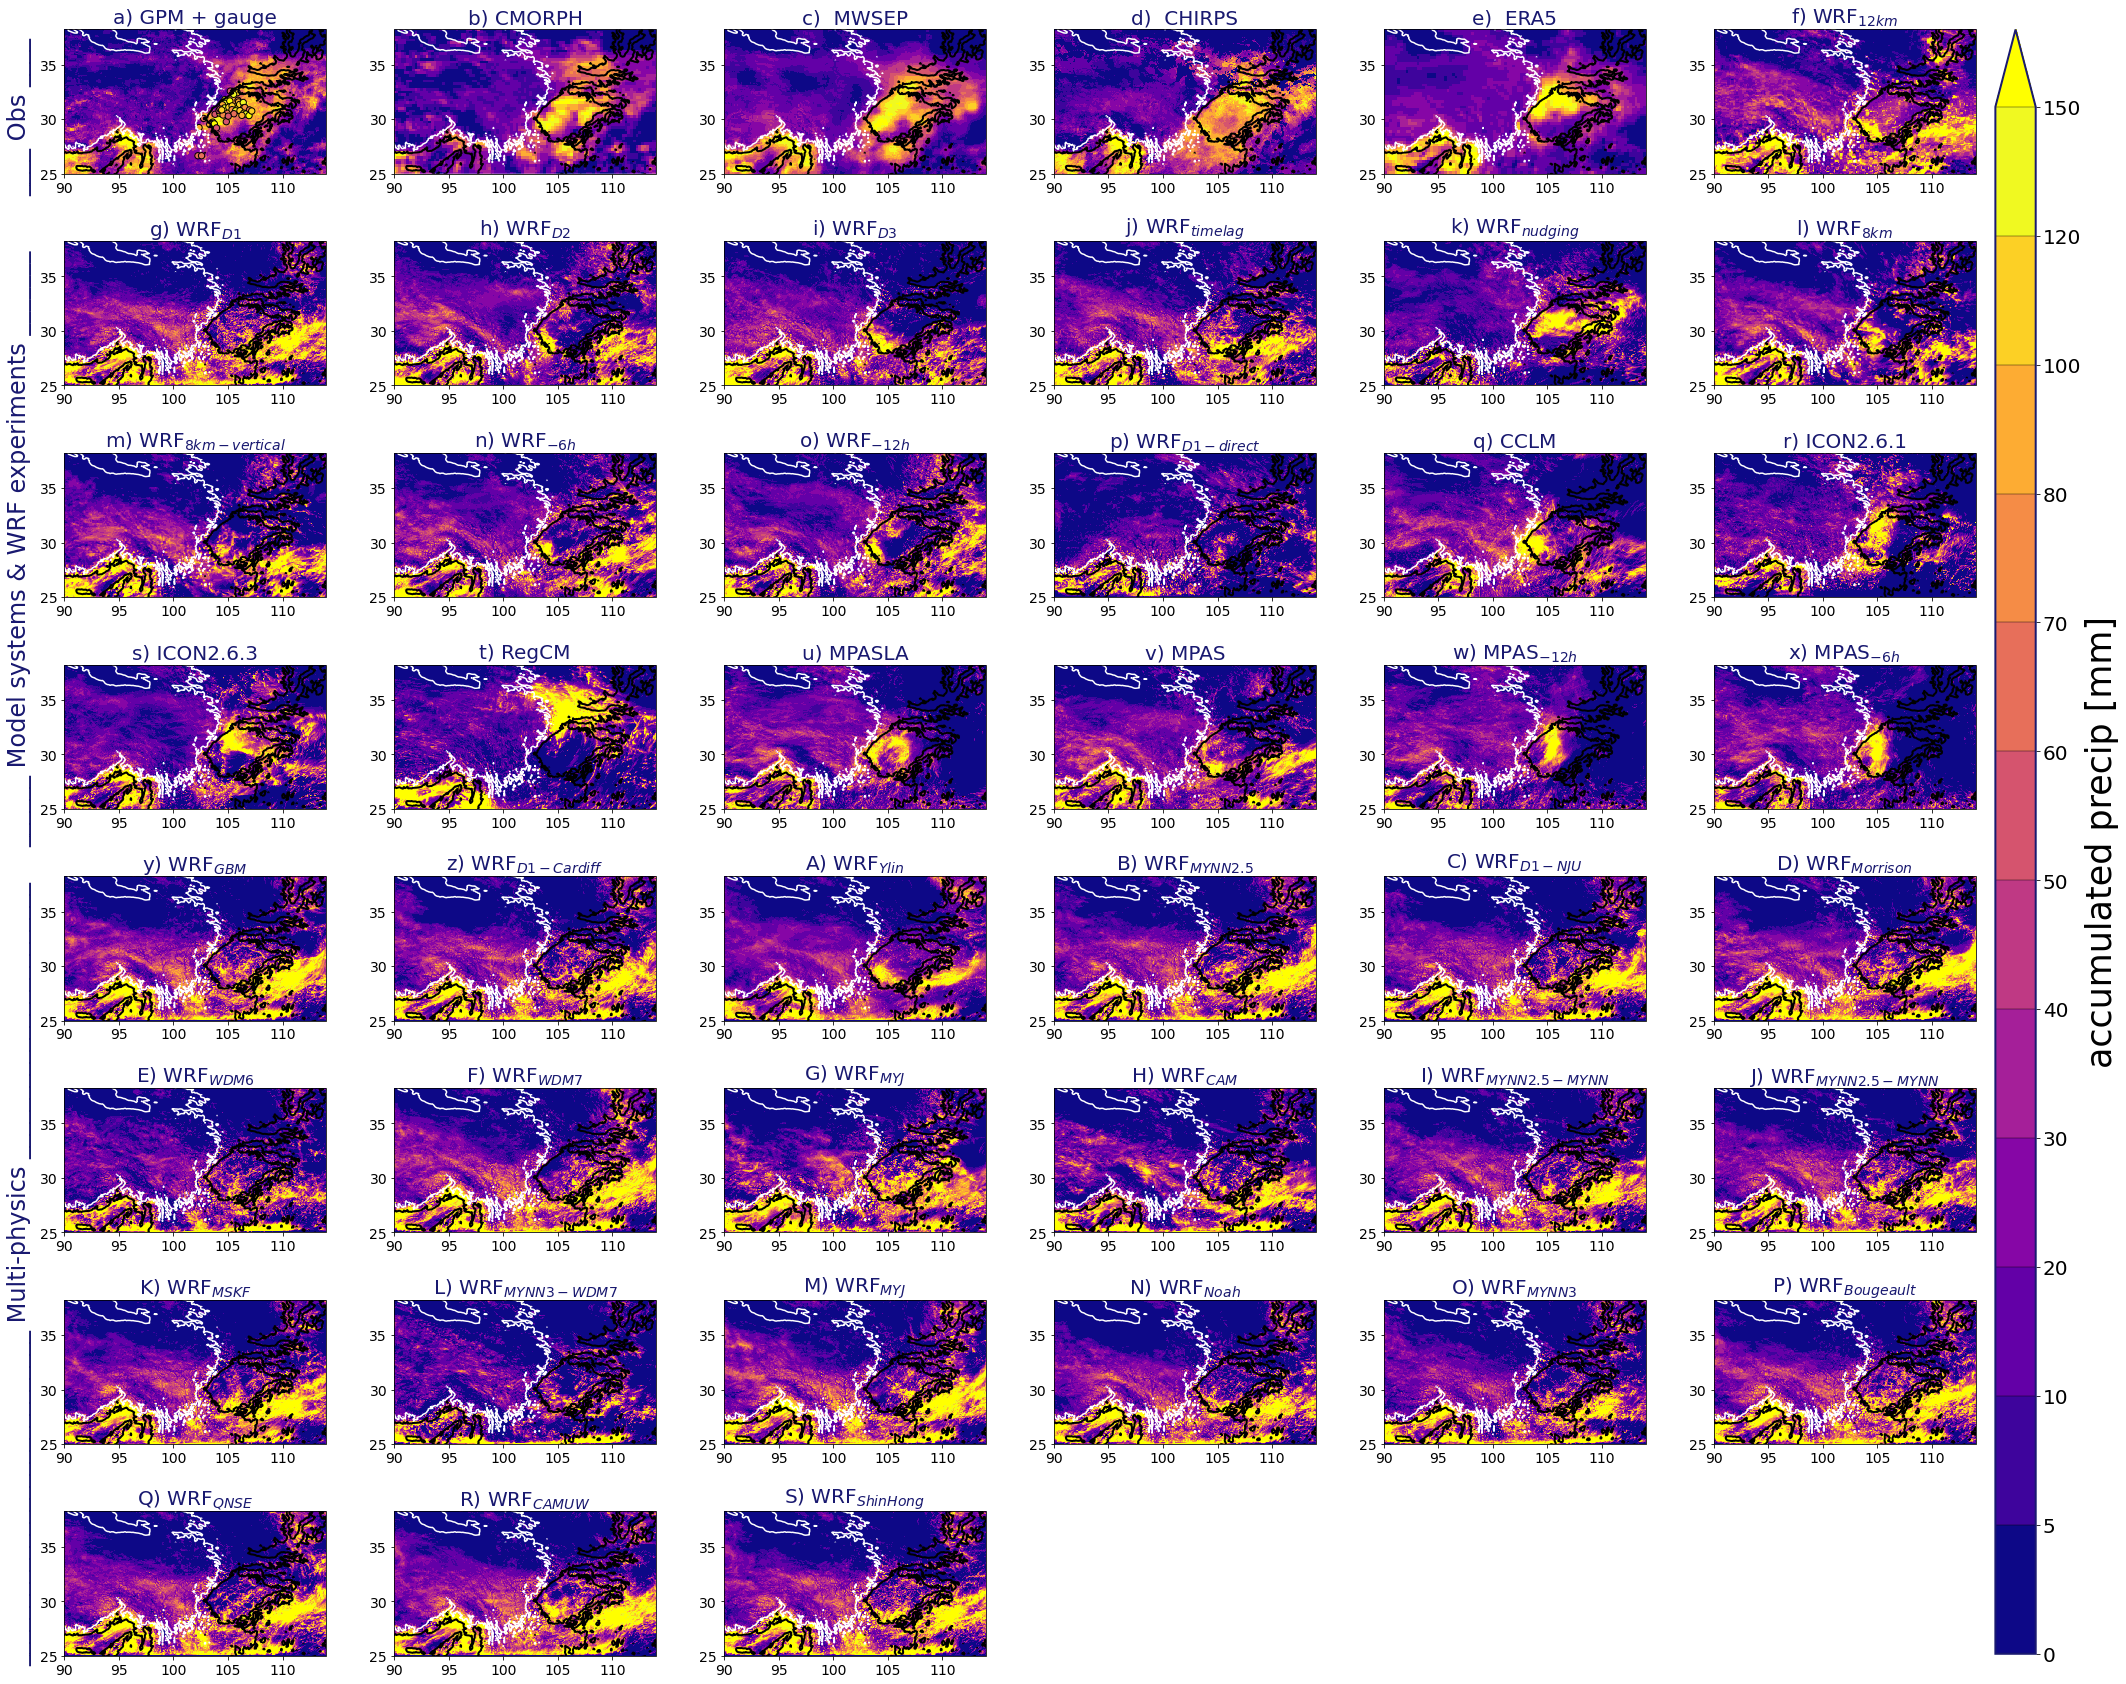

In [17]:
plot_precip_ensemble(ensemble, era_precip_ds, acc_precip_era, acc_precip_era_lsp, acc_precip_era_cp,acc_precip,  'accumulated-precip_ensemble-revised.png')

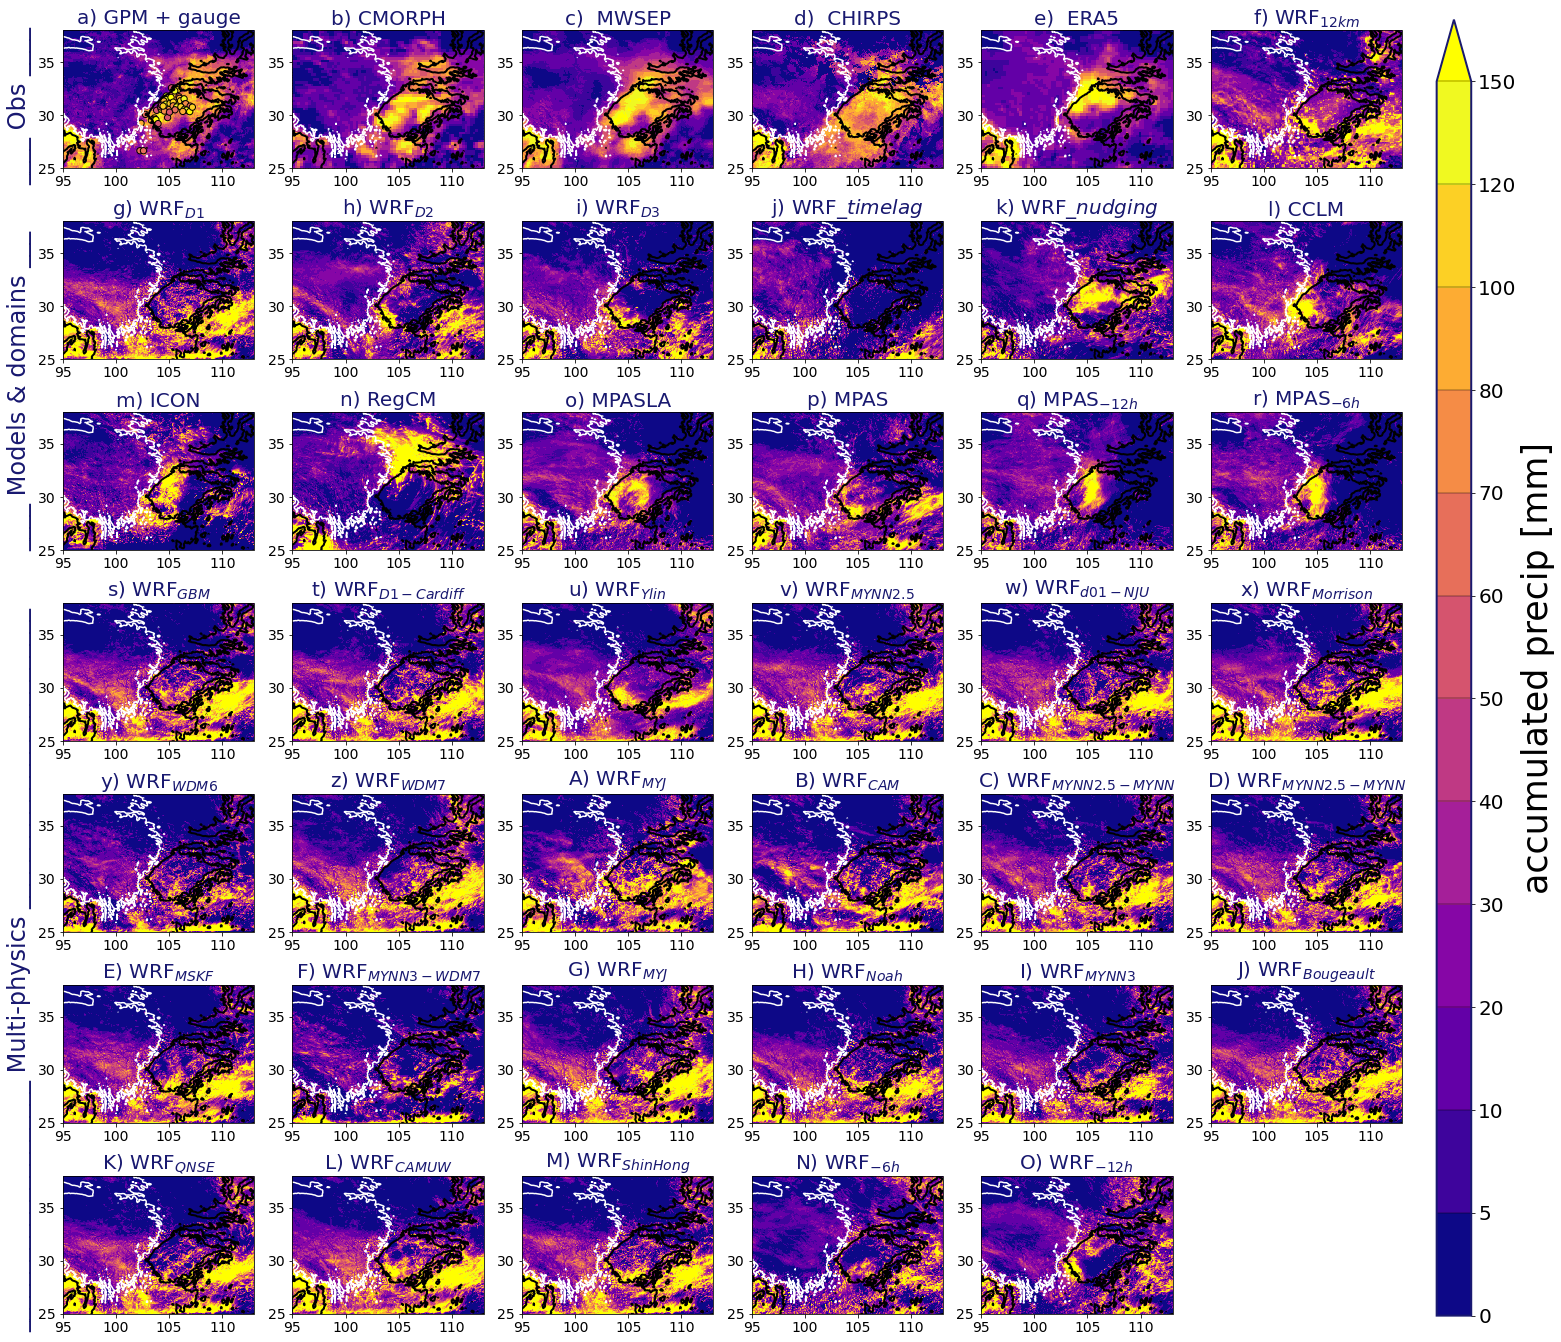

In [13]:
plot_precip_ensemble(ensemble, era_precip_ds, acc_precip_era, acc_precip_era_lsp, acc_precip_era_cp,acc_precip,  'accumulated-precip_ensemble.png')

In [22]:
acc_precip.keys()

dict_keys(['WRF$_{12km}$', 'WRF$_{D1}$', 'WRF$_{D2}$', 'WRF$_{D3}$', 'WRF_${timelag}$', 'WRF_${nudging}$', 'CCLM', 'ICON', 'RegCM', 'MPASLA', 'MPAS', 'MPAS$_{-12h}$', 'MPAS$_{-6h}$', 'r1i1p10_NJU', 'r1i1p1_Cardiff', 'r1i1p1_ITP', 'r1i1p1_JAMSTEC', 'r1i1p1_NJU', 'r1i1p1_NORCE', 'r1i1p1_PSU', 'r1i1p1_UGOT', 'r1i1p1_UHH', 'r1i1p2_Cardiff', 'r1i1p2_JAMSTEC', 'r1i1p2_NJU', 'r1i1p2_UGOT', 'r1i1p3_Cardiff', 'r1i1p3_NJU', 'r1i1p3_UGOT', 'r1i1p4_NJU', 'r1i1p5_NJU', 'r1i1p6_NJU', 'r1i1p7_NJU', 'r1i1p9_NJU', 'r1i3p1_NCAR', 'r1i4p1_NCAR', 'r1i5p1_NCAR'])

In [ ]:
# zoom in to Sichuan basin - for NCAR simulations
plotting.plot_precip([90,115,25,38], precip_data, acc_precip, era_precip_ds, acc_precip_era,  out= 'comparison_accumulated_precip_18-21july2008_zoom.png')

## Timeseries of daily accumulated precipitation 


In [23]:
# get timeseries 
stations= pd.read_csv('/glade/u/home/kukulies/data/obs/stations.csv')
stations_rain = np.array(())
time = np.arange(16,25)
for dd in time:
    stations_rain = np.append(stations_rain, stations[stations.DD == dd].Pinmm.values.sum() )

In [24]:

# add locations to dataframe 
for station in np.unique(stations.station.values):
    stations.loc[stations.station == station, 'lat'] = locations[locations.nr == station].lat.values[0]
    stations.loc[stations.station == station, 'lon'] = locations[locations.nr == station].lon.values[0]

In [26]:
station_lons = stations.lon.values
station_lats = stations.lat.values

In [62]:
start = '2008-07-15-00'
end =  '2008-07-24-23'
era = np.array(())

# get ERA5 precip 
precip_era = analysis.select_time(era_precip_ds, start, end, 'time', era_precip_ds.time.values) * 1000
era_sum = 0 
# daily sum 
daily_era = precip_era.tp.groupby(precip_era.time.dt.day).sum()
# get grid cells from stations 
for dayidx in np.arange(len(daily_era.day.values)):
    daily = daily_era[dayidx]
    for idx in range(len(station_lons)):
        lo = station_lons[idx]
        la = station_lats[idx]
        value = daily.sel(longitude = station_lons[idx], latitude = station_lats[idx], method = 'nearest').values
        era_sum += np.array(value)
    era = np.append(era, era_sum) 
    era_sum = 0 

Text(0, 0.5, 'daily precipitation accumulation [mm]')

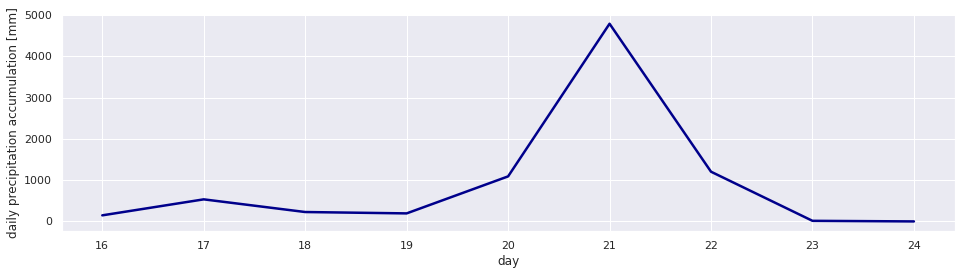

In [66]:
import seaborn as sns
plt.figure(figsize=(16,4))
sns.set()

plt.plot(time, stations_rain, lw = 2.5, color = 'darkblue', label = 'gauge stations')
#plt.plot(np.arange(18,25), era, lw = 2.5, color = 'darkorange', label = 'ERA5')
plt.xlabel('day')
plt.ylabel('daily precipitation accumulation [mm]')

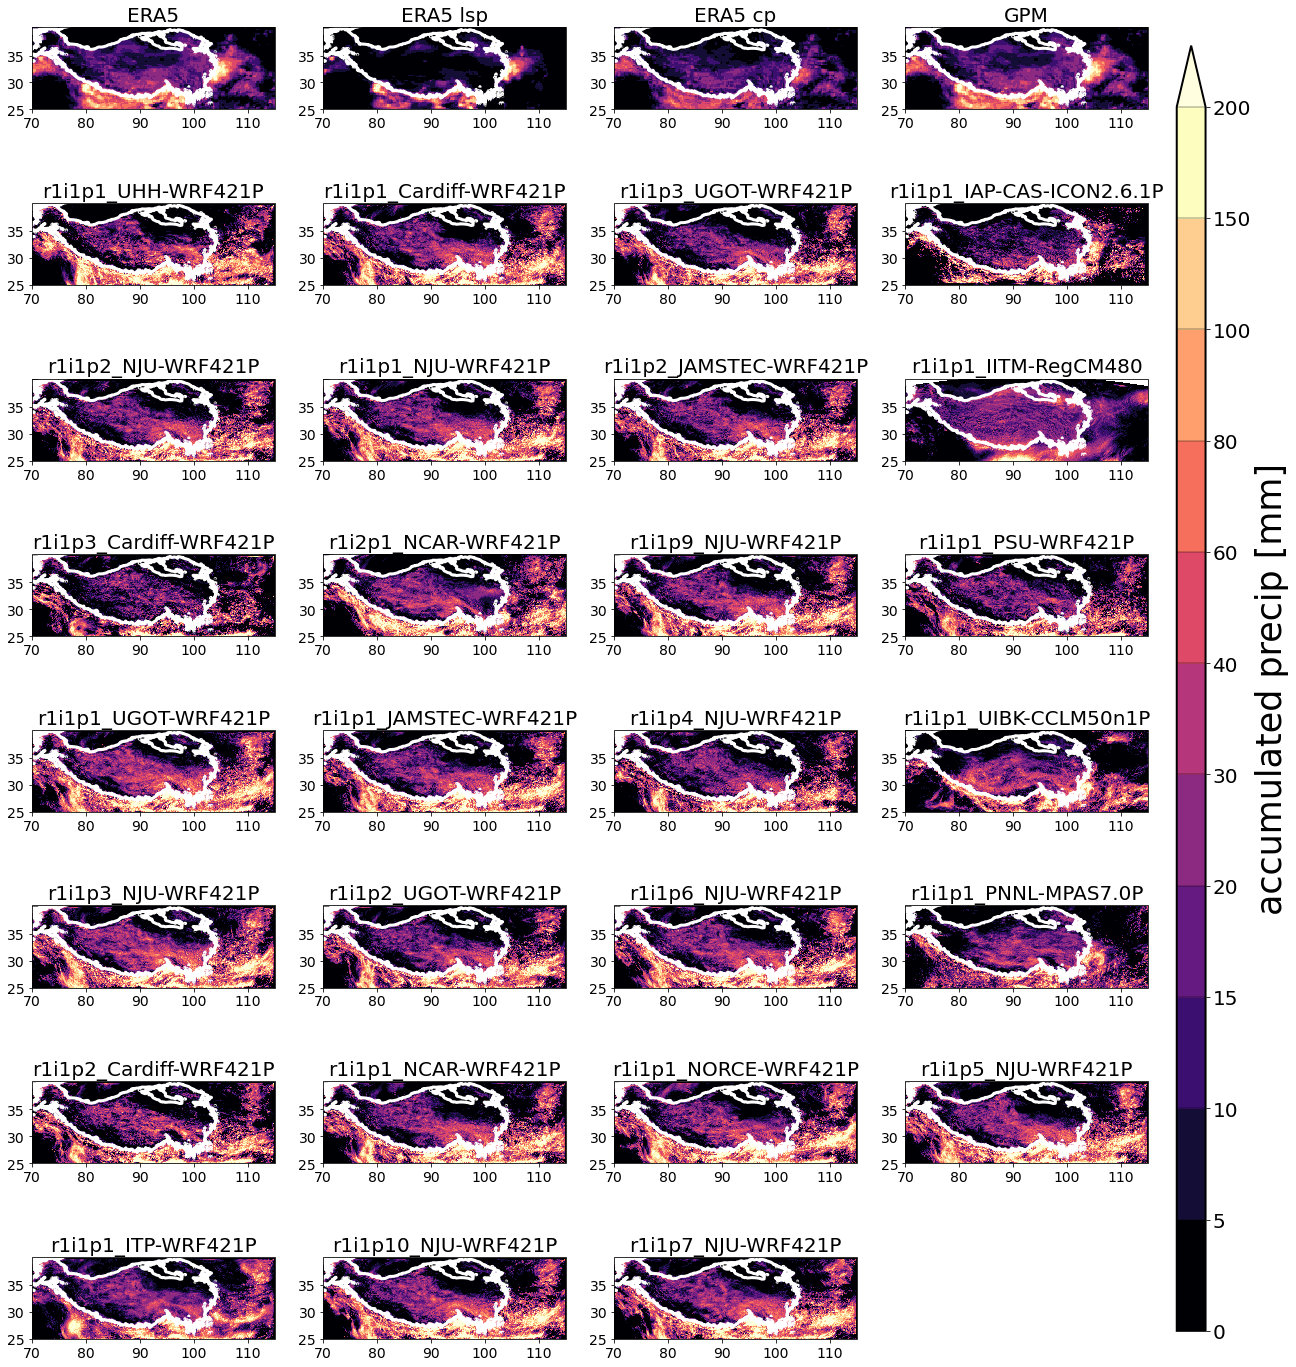

In [59]:
plot_precip_ensemble(ensemble, era_precip_ds, acc_precip_era, acc_precip_era_lsp, acc_precip_era_cp, 'accumulated_precip_ensemble_large.png')

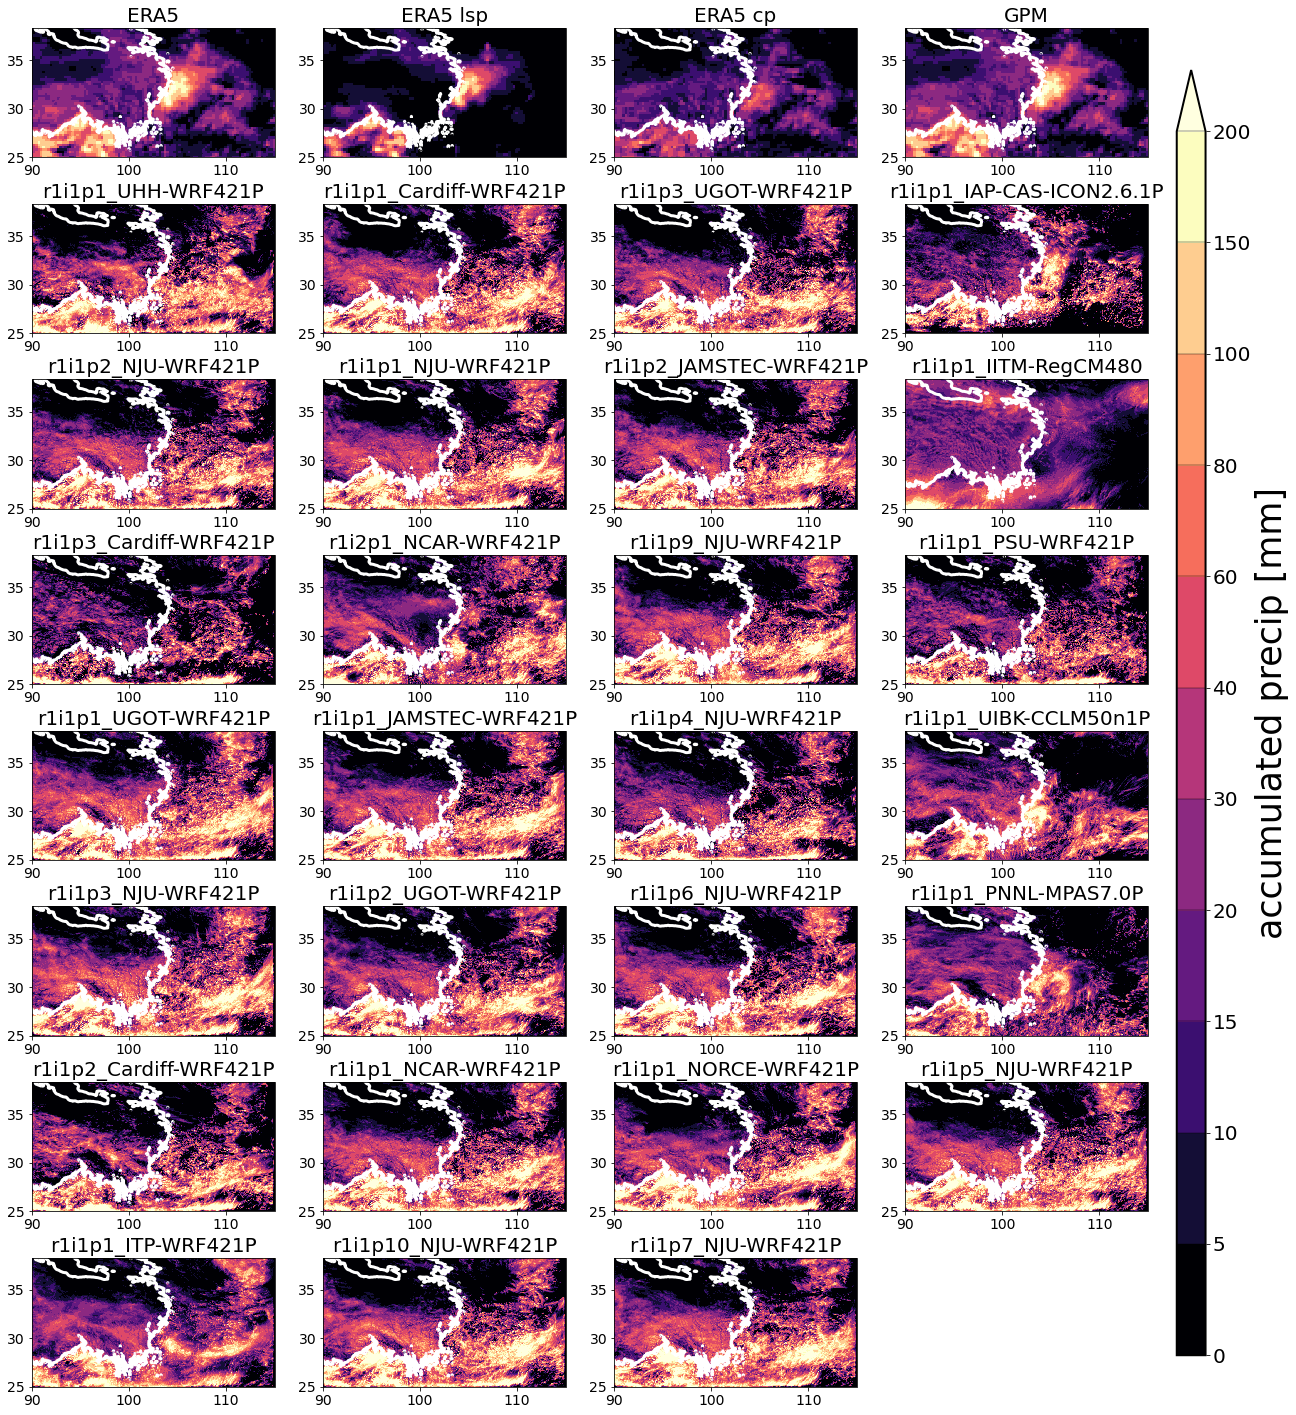

In [57]:
plot_precip_ensemble(ensemble, era_precip_ds, acc_precip_era, acc_precip_era_lsp, acc_precip_era_cp, 'accumulated_precip_ensemble.png')

In [31]:


def plot_precip(extent, precip_data, acc_precip, era_precip_ds, acc_precip_era, out, xlon= None , ylat = None):
    """
    Make subplots of accumulated precipitation of WRF simulations in comparison with ERA5. 
    
    Args:
    extent: extent of map 
    precip_data(dict): dict with WRF experiment names and xarray data sets 
    acc_precip(dict): dict with WRF experiment names and computed accumulated precip in mm
    era_precip_ds(xarray.Dataset): ERA5 precipitation dataset 
    acc_precip_era(array): 2d field of computed accumulated precip in mm
    out(str): name of output file 
    xlon/ylat: array-like, used for xtick and ytick labels 
    
    """
    fig =plt.figure(figsize=(20,10))

    # customizing of colorbar 
    cmap=plt.cm.magma
    cmap.set_over(color='lightyellow')
    #cmap.set_under(color='white')
    r = np.array([0,5,10,15,20,30,40,60,80,100,150])
    norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
    levels = [0,10,20,30,50,100,150,200,250,300,500] 
    fs= 25
    if xlon is None:
        xlon = [90,95,100,105,110,115]
        ylat = [25,30,35]
        
    ax = plt.subplot(2, 2, 1 , projection=ccrs.PlateCarree())
    if extent is not None:
        ax.set_extent(extent)
    m=ax.pcolormesh(era_precip_ds.longitude, era_precip_ds.latitude, acc_precip_era,  cmap = cmap, norm = norm , vmin = 0)
    ax.coastlines(color = 'black')
    ax.contour(lo, la, elevations.data.T, [3000], cmap = 'Greys', linewidths = [3.0])
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title('ERA5', fontsize= fs)

    for idx in np.arange(3):
        # read in data 
        key =list(acc_precip.keys())[idx]
        data= acc_precip[key]
        lon = precip_data[key].lon
        lat = precip_data[key].lat
        # make subplot 
        ax = plt.subplot(2, 2, idx +2 , projection=ccrs.PlateCarree())
        if extent is not None: 
            ax.set_extent(extent)
        m=ax.pcolormesh(lon, lat, data,  cmap = cmap, norm = norm , vmin = 0)
        ax.coastlines(color = 'black')
        ax.contour(lo, la, elevations.data.T, [3000], cmap = 'Greys', linewidths = [3.0])
        ax.set_title(key, fontsize= fs)
        ax.set_xticks(xlon)
        ax.set_xticklabels(xlon, fontsize= 14)
        ax.set_yticks(ylat)
        ax.set_yticklabels(ylat, fontsize= 14)
        data.close()

    cb_ax2 = fig.add_axes([0.92, 0.14,0.02, 0.75])
    cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', ticks = r, drawedges=True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(2)
    cbar.ax.tick_params(labelsize=fs)

    cbar.set_label(r'accumulated precip [mm]', size=35)
    plt.rcParams.update({'font.size': 32})

    plt.savefig(Path('plots/') / out , transparent = None)
    plt.show()



In [33]:
# elevation data for plotting 
dem = '~/data/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
longitude = elevations.lon.values
latitude= elevations.lat.values
lo, la = np.meshgrid(longitude, latitude)

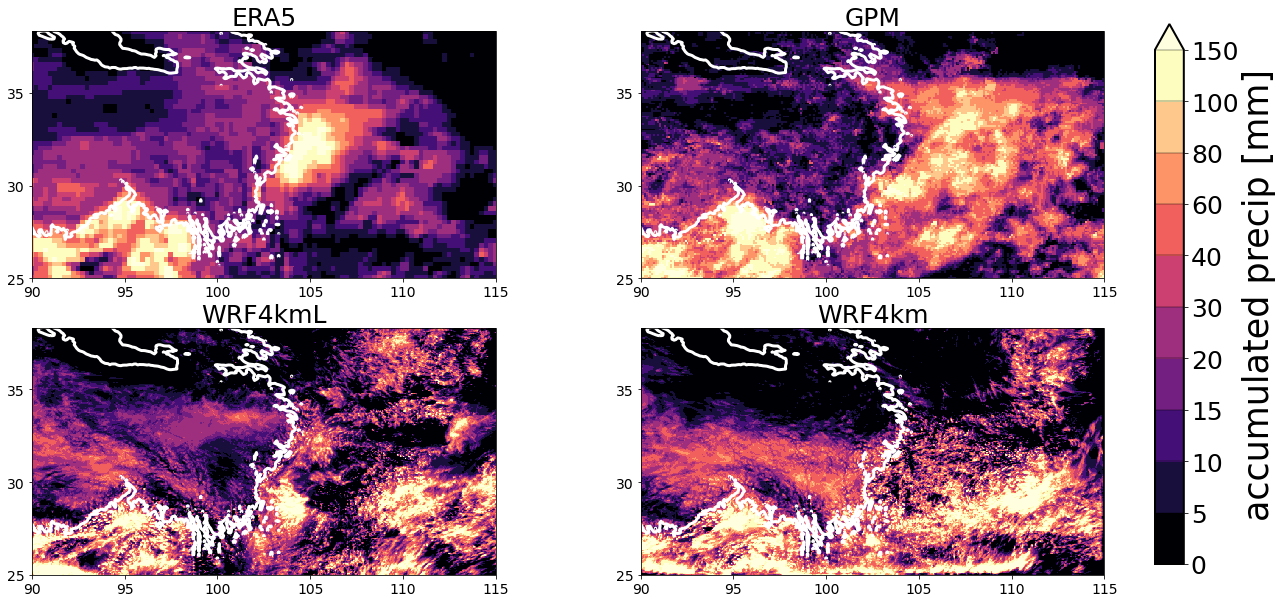

In [42]:
plot_precip([90,115,25,38], precip_data, acc_precip, era_precip_ds, acc_precip_era, out= 'comparison_accumulated_precip_18-21july2008_NCAR_obs.png')

## Taylor diagram of 96-hour accumulated precipitation during event 18-21 July

In [32]:
# calculate accumulated precip for each model and match grid with GPM 
models = []

for ens in ensemble: 
    print(ens.stem)
    ds = xr.open_dataset(ens)
    precip = ds.pr[96:96*2] * 3600
    try:
        wrf_accumulated = precip.sum('Time')
    except:
        wrf_accumulated= precip.sum('time')

    # bring to common grid 
    gpm, wrf_interp = analysis.common_grid_gpm(gpm_accumulated, wrf_accumulated)
    models.append(wrf_interp)

pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_UHH-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_Cardiff-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p3_UGOT-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p2_NJU-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NJU-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p2_JAMSTEC-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p3_Cardiff-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_NCAR-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p9_NJU-WRF421P_v1_hour_20080714-20080724
pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PSU-WRF421P_v1_hour_20080714-20080724
pr_CP

In [39]:
# compute statistics 
crmsd, ccoef, mean, sdev = analysis.get_stats(gpm.values, models)
# all labels 
experiments = analysis.get_experiments(ensemble, 'evaluation_', '_v1_hour')
labels =["GPM"] + experiments

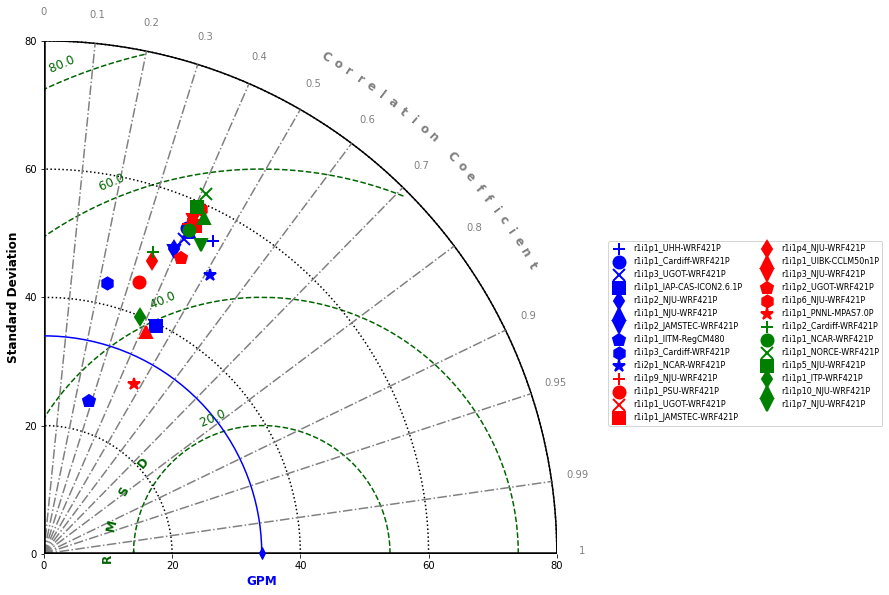

In [49]:
import skill_metrics as sm
plt.figure(num=1, figsize=(15, 10))

sm.taylor_diagram(sdev,crmsd, ccoef, markerLabel = labels, markerLabelColor = 'r', 
                  markerLegend = 'on', markerColor = 'b',
                  styleOBS = '-', colOBS = 'b', markerobs = 'd',
                  markerSize = 12,  showlabelsRMS = 'on',
                  titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on', colRMS= 'darkgreen', colCOR= 'grey', titleSTD= 'on')

plt.savefig('taylor_diagram_accumulated_precip_ensemble.png')
plt.show()